# Starbucks Capstone Challenge

![Starbucks](https://pbs.twimg.com/media/FgpCF0BXEAAU23C?format=jpg&name=4096x4096)

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id 
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [265]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MultiLabelBinarizer
from datetime import datetime



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from sklearn.utils.multiclass import unique_labels

In [693]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration & Cleaning 👀👨‍💻🧹

In [364]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Here is a little function that will save us time on this project (as well as future projects) 😎
def data_intro(data):
    print("\033[4mFirst 5 rows of data:\033[0m", '\n'*2, data.head(), '\n'*2)
    print("\033[4mData Info:\033[0m", '\n')
    print(data.info(),'\n'*2)
    print("\033[4mBasic statistics for numeric features:\033[0m", '\n'*2, data.describe(include=np.number), '\n'*2)
    print("\033[4mNULL value examination (%):\033[0m", '\n'*2, round(100 * data.isnull().sum()/len(data), 2), '\n'*2)
    print("\033[4mBarchart of existing values (Full bar indicates no missing values):\033[0m",'\n')
    plt.title('Barchart of present values (Full bar indicates no missing values)', fontsize=30)
    plt.xlabel('Features', fontsize=25)
    plt.ylabel('%', fontsize=25)
    msno.bar(data)
    plt.show()
    print('\n')
    print("\033[4mPaired plot for features:\033[0m", '\n')
    sns.pairplot(data)
    plt.show()

## Dataset 1: Portfolio 💼 

First 5 rows of data: 

    reward                      channels  difficulty  duration     offer_type                                id
0      10       [email, mobile, social]          10         7           bogo  ae264e3637204a6fb9bb56bc8210ddfd
1      10  [web, email, mobile, social]          10         5           bogo  4d5c57ea9a6940dd891ad53e9dbe8da0
2       0          [web, email, mobile]           0         4  informational  3f207df678b143eea3cee63160fa8bed
3       5          [web, email, mobile]           5         7           bogo  9b98b8c7a33c4b65b9aebfe6a799e6d9
4       5                  [web, email]          20        10       discount  0b1e1539f2cc45b7b9fa7c272da2e1d7 


Data Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null    

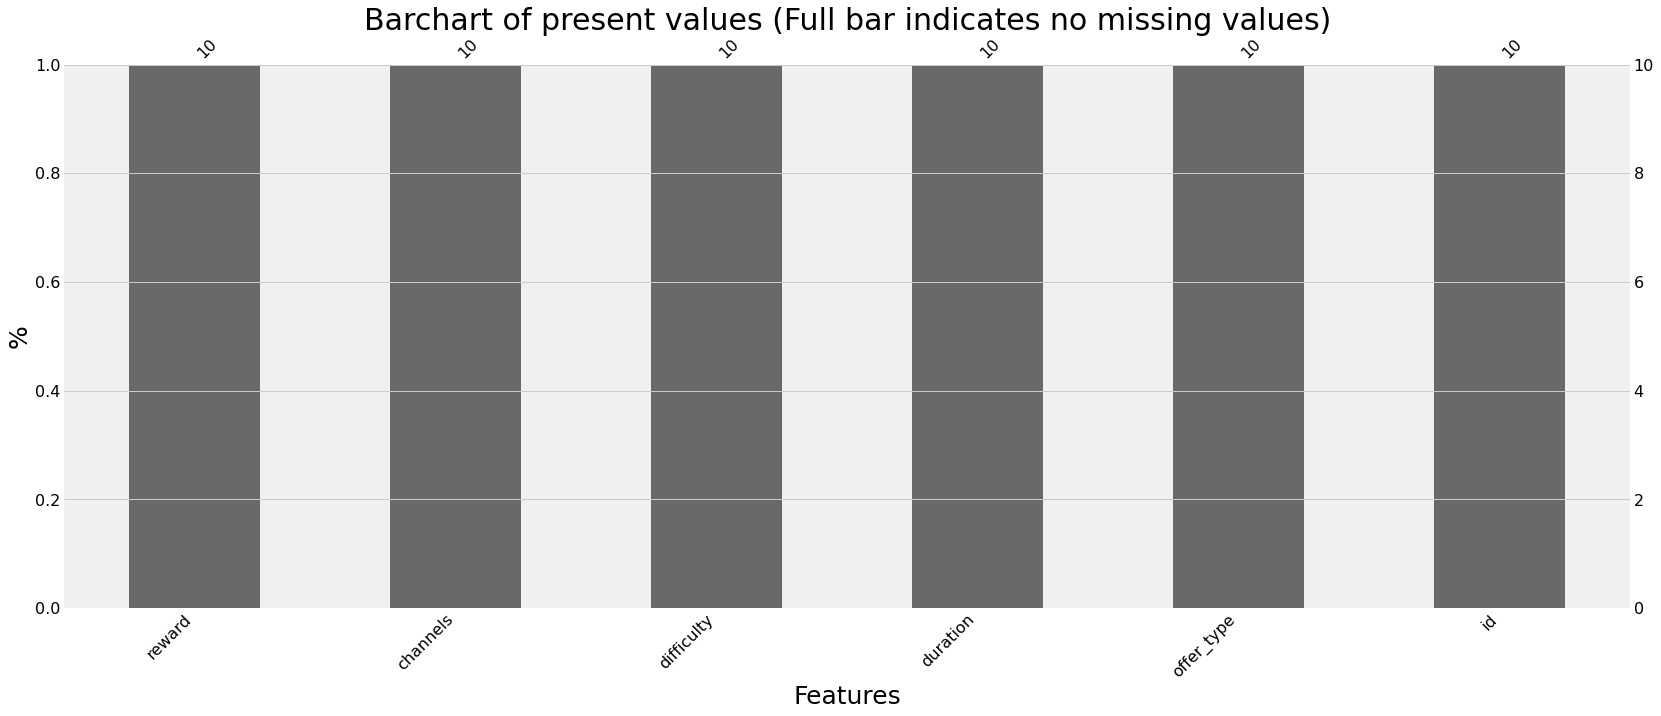



Paired plot for features: 



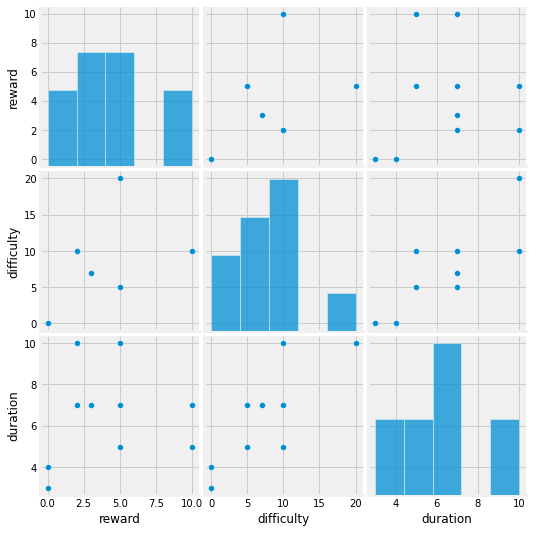

In [365]:
data_intro(portfolio)

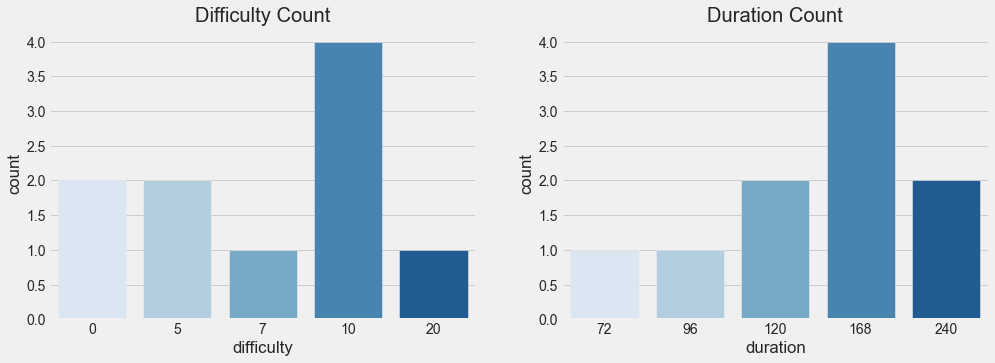

In [264]:
plt.style.use("fivethirtyeight")
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.countplot(portfolio.difficulty, ax=axs[0],palette='Blues');
axs[0].set_title('Difficulty Count')

sns.countplot(portfolio.duration, ax=axs[1],palette='Blues');
axs[1].set_title('Duration Count');

#### Observations:

- Change the name of 'id' to 'offer_id' so it makes more sense going forward

- The `channels` column seems useful, but each value is a list. Therefore, we will apply OneHotEncoding (off=0, on=1) by leveraging scikit-learns `MultiLabelBinarizer` (this simplifies OneHotEncoding for a column containing lists in each row)

- Apply OneHotEncoding on `offer_type` column


## Cleaning: Portfolio 💼

In [318]:
from sklearn.preprocessing import MultiLabelBinarizer

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)

def clean_portfolio(portfolio):
    '''
    Function to clean the portfolio dataset:
        - rename 'id' column to 'offer_id' and set it as the first column
        - One-hot-encode categorical variables (using sklearn.preprocessing.MultiLabelBinarizer)
        - One-hot-encode 'offer_types' with pd.get_dummies 
🔥      - Change the duration from days to hours
        
    
    Input: Original portfolio dataframe
    
    Output: Cleaned portfolio dataframe
    '''

    # rename 'id' column to 'column_id' and set it as the first column
    portfolio.rename(columns={'id':'offer_id'}, inplace=True)
    first_column = portfolio.pop('offer_id')
    portfolio.insert(0, 'offer_id', first_column)
    portfolio.dropna(inplace=True)
    
    # One-hot-encode for 'channels' column:
    # note: we could accomplish this by looping through a list ['web', 'email', 'social', 'mobile'] 
    # by expanding on the example below, but this would be suboptimal if the list was much longer
            # example: portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    portfolio_copy = portfolio.copy()
    
    # Commented obtains a sparse form: I later realized that this is not always compatable with several functions for EDA
    # mlb = MultiLabelBinarizer(sparse_output=False)
    # portfolio_copy = portfolio_copy.join(
    #             pd.DataFrame.sparse.from_spmatrix(
    #             mlb.fit_transform(portfolio_copy.pop('channels')),
    #             index=portfolio_copy.index,
    #             columns=mlb.classes_))
    
    # One-hot-encode categorical variables (using sklearn.preprocessing.MultiLabelBinarizer)
    mlb = MultiLabelBinarizer()
    portfolio_copy = portfolio_copy.join(
        pd.DataFrame(mlb.fit_transform(portfolio_copy.pop('channels')),
                          columns=mlb.classes_,
                          index=portfolio_copy.index))
    
    # One-hot-encode 'offer_type' 
        # Reasoning: When we have a categorical variable with K mutually exclusive categories, you actually only need K – 1 new dummy variables to encode the same information.
    portfolio_cleaned = pd.get_dummies(portfolio_copy, 
                                    columns = ['offer_type'])
    
    # change the duration from days to hours
    portfolio_cleaned['duration'] = portfolio_cleaned['duration'] * 24
    
    
    return portfolio_cleaned

portfolio = clean_portfolio(portfolio)

In [317]:
portfolio

,offer_id,reward,difficulty,duration,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,168,1,1,1,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,120,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,0,96,1,1,0,1,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,168,1,1,0,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,240,1,0,0,1,0,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,168,1,1,1,1,0,1,0
6,fafdcd668e3743c1bb461111dcafc2a4,2,10,240,1,1,1,1,0,1,0
7,5a8bc65990b245e5a138643cd4eb9837,0,0,72,1,1,1,0,0,0,1
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,120,1,1,1,1,1,0,0
9,2906b810c7d4411798c6938adc9daaa5,2,10,168,1,1,0,1,0,1,0


In [369]:
portfolio.dtypes

offer_id                    object
reward                       int64
difficulty                   int64
duration                     int64
email                        int64
mobile                       int64
social                       int64
web                          int64
offer_type_discount          uint8
offer_type_informational     uint8
offer_type_nan               uint8
dtype: object

# Dataset 2:  Profile ⌮

First 5 rows of data: 

   gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN 


Data Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB
No

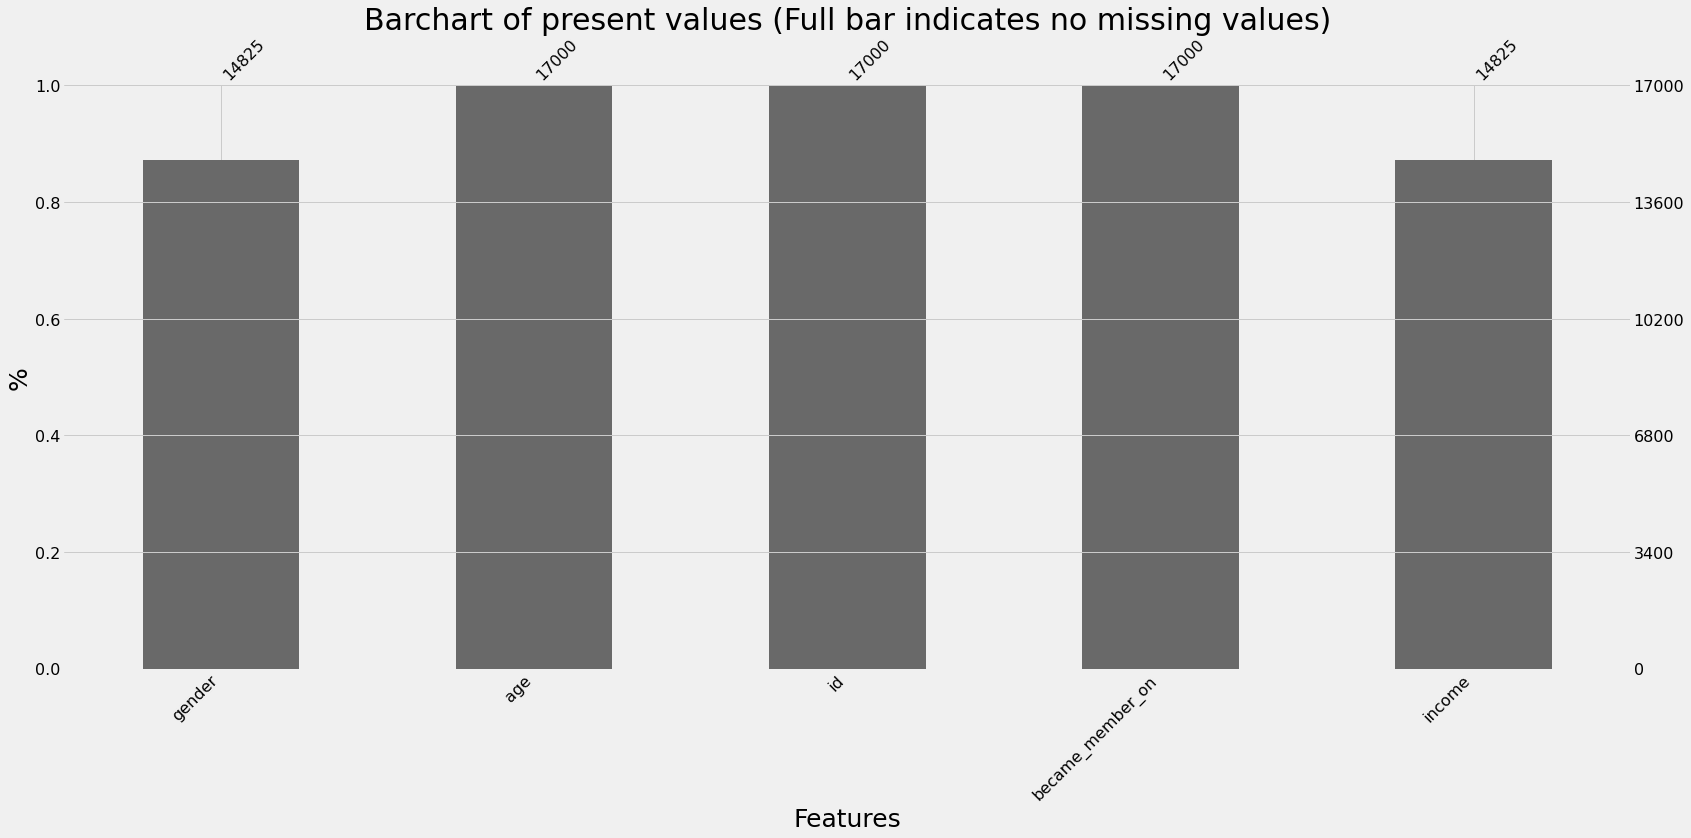



Paired plot for features: 



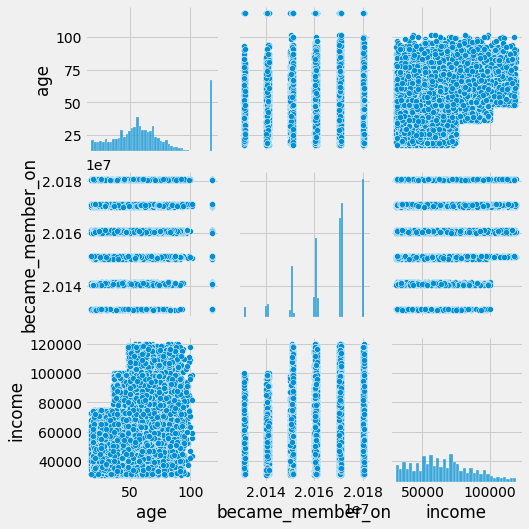

In [370]:
data_intro(profile)

In [93]:
df = profile.copy()
df = df.dropna(how='any')
df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d')
df['became_member_year'] , df['became_member_month'] = df.became_member_on.dt.year.values, df.became_member_on.dt.month.values

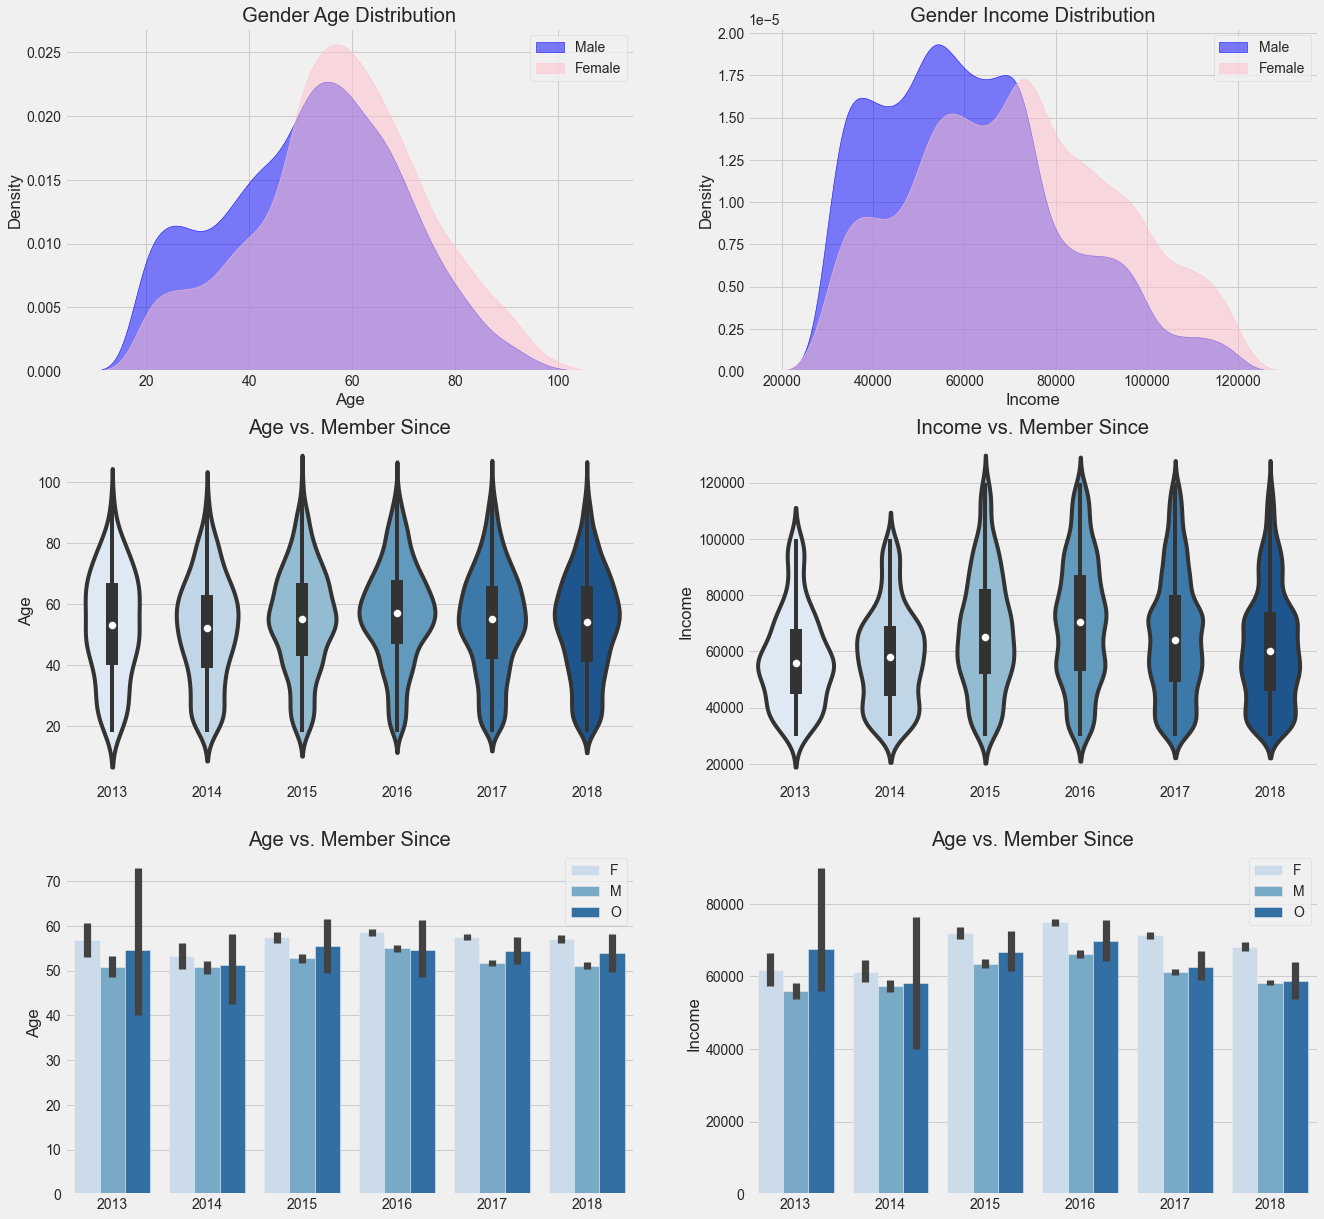

In [87]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,20))


plt.style.use("fivethirtyeight")
sns.distplot(df[df['gender']=='M']['age'],color='blue',ax=axs[0,0], label='Male', kde_kws={'alpha': 0.5, 'shade':True}, hist=False);
sns.distplot(df[df['gender']=='F']['age'],color='pink',ax=axs[0,0], label='Female', kde_kws={'alpha': 0.5, 'shade':True}, hist=False);
axs[0,0].set_title('Gender Age Distribution')
axs[0,0].set_xlabel('Age')
axs[0,0].legend()

sns.distplot(df[df['gender']=='M']['income'],color='blue',ax=axs[0,1], label='Male', kde_kws={'alpha': 0.5, 'shade':True}, hist=False);
sns.distplot(df[df['gender']=='F']['income'],color='pink',ax=axs[0,1], label='Female', kde_kws={'alpha': 0.5, 'shade':True}, hist=False);
axs[0,1].set_title('Gender Income Distribution')
axs[0,1].set_xlabel('Income')
axs[0,1].legend()

sns.violinplot(data=df, x="became_member_year", y="age",palette='Blues',ax=axs[1,0])
axs[1,0].set_title('Age vs. Member Since')
axs[1,0].set_ylabel('Age')
axs[1,0].set_xlabel('')

sns.violinplot(data=df, x="became_member_year", y="income",palette='Blues',ax=axs[1,1])
axs[1,1].set_title('Income vs. Member Since')
axs[1,1].set_ylabel('Income')
axs[1,1].set_xlabel('')

sns.barplot(data=df, x="became_member_year", y="age", hue="gender",palette='Blues',ax=axs[2,0])
axs[2,0].set_title('Age vs. Member Since')
axs[2,0].set_ylabel('Age')
axs[2,0].set_xlabel('')
axs[2,0].legend(loc='upper right')

sns.barplot(data=df, x="became_member_year", y="income", hue="gender",palette='Blues',ax=axs[2,1])
axs[2,1].set_title('Age vs. Member Since')
axs[2,1].set_ylabel('Income')
axs[2,1].set_xlabel('')
axs[2,1].legend(loc='upper right');


#### Observations:


- `Age` seems to be approximately normally distributed apart from 2,175 outliers aged 118 years

- Interestingly, both `gender` and `income` have the same % of missing values. -- After some sifting, I noticed that the 2,175 outliers ages 118 years were the ones missing `gender` and `income`

- `became_member_on` should be in readable date time format

- Membership has been monotonically increasing on a yearly basis from 2013-2018

- There is a decent overlap between Gender and Age for both males and females.

- Females income approximates closer to a normal distribution than that of males. Moreover, the female population has higher salary overall.

- Loosely speaking, most customers are middle aged


In [290]:
profile = pd.read_json('data/profile.json', orient='records', lines=True)


cust_id_4_age_118 = profile[(profile['age']==118)][['id']].values
cust_id_4_age_118 = [item for sublist in cust_id_4_age_118 for item in sublist]
# len(cust_id_4_age_118) # 2175
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [291]:
def clean_profile(profile):
    '''
    Function to clean the profile dataset:
        - drop rows where age == 118
        - drop rows with NaNs
        - rename 'id' column to 'customer_id' and set it as the first column
        - convert 'became_member_on' to more readable datetime format
        - One-hot-encode 'gender'
        - Seperate 'age' into 'age_by_decade'
        - OneHotEncoding feature 'age_by_decade'
        - create income range & One-hot-encode it
        - create a column for # days customer has been a member
        - Add a 'Year' & 'Month' columns
        
        - One-hot-encode categorical variables   (using sklearn.preprocessing.MultiLabelBinarizer)
        - leverage pd.get_dummies on offer_types 
        - set 'offer
    
    Input: Original portfolio dataframe
    
    Output: Cleaned portfolio dataframe
    '''
    
    # drop rows where age == 118 & reset_index
    profile.drop(profile[profile.age == 118].index, inplace=True)
    profile.reset_index(drop=True, inplace = True)
    # drop rows with NaNs 
    profile.dropna(inplace=True)
    
    # rename 'id' column to 'customer_id' and set it as the first column
    profile.rename(columns={'id':'customer_id'}, inplace=True)
    first_column = profile.pop('customer_id')
    profile.insert(0, 'customer_id', first_column)
    
    # convert 'became_member_on' to more readable datetime format
    profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
    
    # One-hot-encode 'gender'
    profile = pd.get_dummies(profile, columns = ['gender'])
    
    # Seperate 'age' into 'age_by_decade'
    profile['age_by_decade'] = pd.cut(profile['age'], bins=range(10,120,10),right=False, labels=['10s','20s', '30s', '40s', '50s','60s', '70s', '80s', '90s', '100s'])

    # OneHotEncoding feature 'age_by_decade'
    profile = pd.get_dummies(profile, columns=['age_by_decade'])
    
    # create income range & One-hot-encode it
    profile['income_by_range'] = pd.cut(profile['income'], bins=range(30000,140000,10000), right=False,\
                                        labels=['30ths','40ths', '50ths', '60ths', '70ths','80ths', '90ths',\
                                                '100ths', '110ths', '120ths'])
    profile = pd.get_dummies(profile,
                             columns=['income_by_range'], 
                             prefix='income', 
                             prefix_sep='_')

    # create a column for # days customer has been a member
    current_date = pd.to_datetime(datetime.today().strftime('%Y%m%d'))
    profile['membership_days'] = (current_date - profile['became_member_on']) / np.timedelta64(1,'D')
    
    # Add a 'Year' & 'Month' columns
    profile['became_member_year'] , profile['became_member_month'] = profile.became_member_on.dt.year.values, profile.became_member_on.dt.month.values  
    
    
    return profile


profile = clean_profile(profile)

In [382]:
profile.head()

,customer_id,age,became_member_on,income,gender_F,gender_M,gender_O,age_by_decade_10s,age_by_decade_20s,age_by_decade_30s,...,income_60ths,income_70ths,income_80ths,income_90ths,income_100ths,income_110ths,income_120ths,membership_days,became_member_year,became_member_month
0,0610b486422d4921ae7d2bf64640c50b,55,2017-07-15,112000.0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,2013.0,2017,7
1,78afa995795e4d85b5d9ceeca43f5fef,75,2017-05-09,100000.0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,2080.0,2017,5
2,e2127556f4f64592b11af22de27a7932,68,2018-04-26,70000.0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1728.0,2018,4
3,389bc3fa690240e798340f5a15918d5c,65,2018-02-09,53000.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1804.0,2018,2
4,2eeac8d8feae4a8cad5a6af0499a211d,58,2017-11-11,51000.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1894.0,2017,11


# Dataset 3:  Transcript 

First 5 rows of data: 

                              person           event                                             value  time
0  78afa995795e4d85b5d9ceeca43f5fef  offer received  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0
1  a03223e636434f42ac4c3df47e8bac43  offer received  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0
2  e2127556f4f64592b11af22de27a7932  offer received  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0
4  68617ca6246f4fbc85e91a2a49552598  offer received  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0 


Data Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306

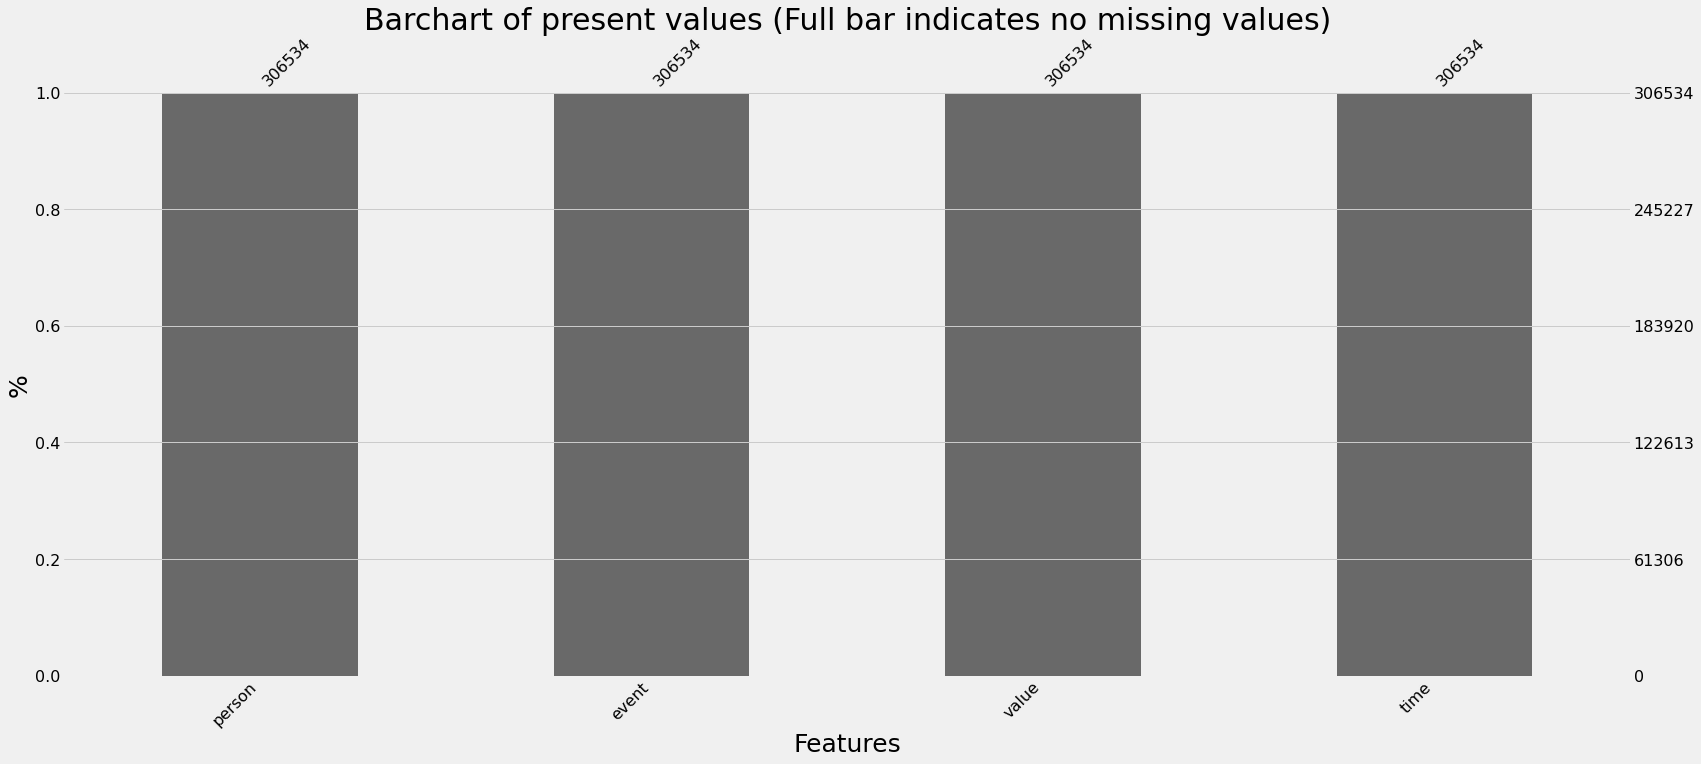



Paired plot for features: 



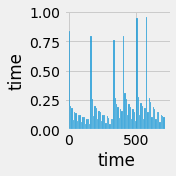

In [374]:
data_intro(transcript)

In [349]:
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

def clean_transcript(transcript):
    '''
    Function to clean the transcript dataset:
    
        - Change 'person' column name to 'customer_id'
        - Remove observations having customers with age 118
        - Extract the 'offer_id' from 'value' column
        - Create seperate columns for 'reward' and 'amount' (using existing 'value' column)
        - Drop 'value' after extracting data from it
        - Group by customer id and reset index
        - We want to distinguish people who KNOWINGLY participated in an offer as opposed to customers who participated in an offer by chance:
            - Successful offers <=> where offer completed and offer viewed are 1≤.
        - Fill all NA with '0'
        
        
    Input: Original transcript dataframe
    
    Output: Cleaned transcript dataframe
    '''

    # change 'person' column name to 'customer_id'
    transcript.rename(columns={'person':'customer_id'},inplace=True)    
    
    # Remove observations having customers with age 118
    transcript = transcript[~transcript['customer_id'].isin(cust_id_4_age_118)]
    
    # Extract the 'offer_id' from 'value'
    transcript['offer_id'] = transcript['value'].apply(lambda x: x['offer_id'] if 'offer_id' in x else 
                                                       (x['offer id'] if 'offer id' in x else None))
    
    # Create seperate columns for 'reward' and 'amount' (using existing 'value' column)
    for i in ['reward','amount']:
        transcript[i] = transcript['value'].apply(lambda x: x[i] if i in x else None)

    # drop 'value' after extracting data from it
    transcript.drop('value', axis=1, inplace=True)
    
    # Group by customer id and reset index
    df = transcript.groupby(['customer_id','offer_id','event'])['time'].count().unstack()
    df.reset_index(level=[0,1],inplace = True)

    # This is important because we want to distinguish customers who KNOWINGLY participated in an offer as opposed to customers who participated by chance 
    df['successful_offer'] = df['offer viewed'] * df['offer completed']
    df['successful_offer'] = df['successful_offer'].apply(lambda x: 1.0 if x > 0 else 0.0)
    df.drop(['offer completed'],axis=1, inplace = True)

    # Fill all NA with '0'
    df.fillna(0.0, inplace=True)
    return df

transcript = clean_transcript(transcript)
transcript

event,customer_id,offer_id,offer received,offer viewed,successful_offer
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1.0,0.0,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1.0,1.0,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1.0,1.0,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0
...,...,...,...,...,...
55217,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2.0,2.0,1.0
55218,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,1.0,1.0
55219,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,3.0,3.0,1.0
55220,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,1.0


In [375]:
# Merge all dataframes together:

# merge transcript with portfolio on 'offer_id'
master_df = transcript.merge(portfolio, how='left', on='offer_id')
# merge master with profile on 'customer_id'
master_df = master_df.merge(profile, how='left', on='customer_id')

# Clean up 'offer_id' column
ten_unique_ids = list(master_df['offer_id'].unique())
for i in range(len(ten_unique_ids)):
    master_df['offer_id'] = master_df['offer_id'].apply(lambda x: f'{i+1}' if x == ten_unique_ids[i] else x)
    
master_df.head()

,customer_id,offer_id,offer received,offer viewed,successful_offer,reward,difficulty,duration,email,mobile,...,income_60ths,income_70ths,income_80ths,income_90ths,income_100ths,income_110ths,income_120ths,membership_days,became_member_year,became_member_month
0,0009655768c64bdeb2e877511632db8f,1,1.0,0.0,0.0,2,10,168,1,1,...,0,1,0,0,0,0,0,2098.0,2017,4
1,0009655768c64bdeb2e877511632db8f,2,1.0,1.0,0.0,0,0,96,1,1,...,0,1,0,0,0,0,0,2098.0,2017,4
2,0009655768c64bdeb2e877511632db8f,3,1.0,1.0,0.0,0,0,72,1,1,...,0,1,0,0,0,0,0,2098.0,2017,4
3,0009655768c64bdeb2e877511632db8f,4,1.0,1.0,1.0,5,5,120,1,1,...,0,1,0,0,0,0,0,2098.0,2017,4
4,0009655768c64bdeb2e877511632db8f,5,1.0,1.0,1.0,2,10,240,1,1,...,0,1,0,0,0,0,0,2098.0,2017,4


In [364]:
#(master_df.query('offer_id  == "2" & successful_offer == 0'))
# master_df = master_df[(master_df['offer_id'] != '2') & (master_df['offer_id'] != '3')]

In [114]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32232 entries, 1 to 55221
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_id               32232 non-null  object        
 1   offer_id                  32232 non-null  object        
 2   offer received            32232 non-null  float64       
 3   offer viewed              32232 non-null  float64       
 4   successful_offer          32232 non-null  float64       
 5   reward                    32232 non-null  int64         
 6   difficulty                32232 non-null  int64         
 7   duration                  32232 non-null  int64         
 8   email                     32232 non-null  int64         
 9   mobile                    32232 non-null  int64         
 10  social                    32232 non-null  int64         
 11  web                       32232 non-null  int64         
 12  offer_type_bogo   

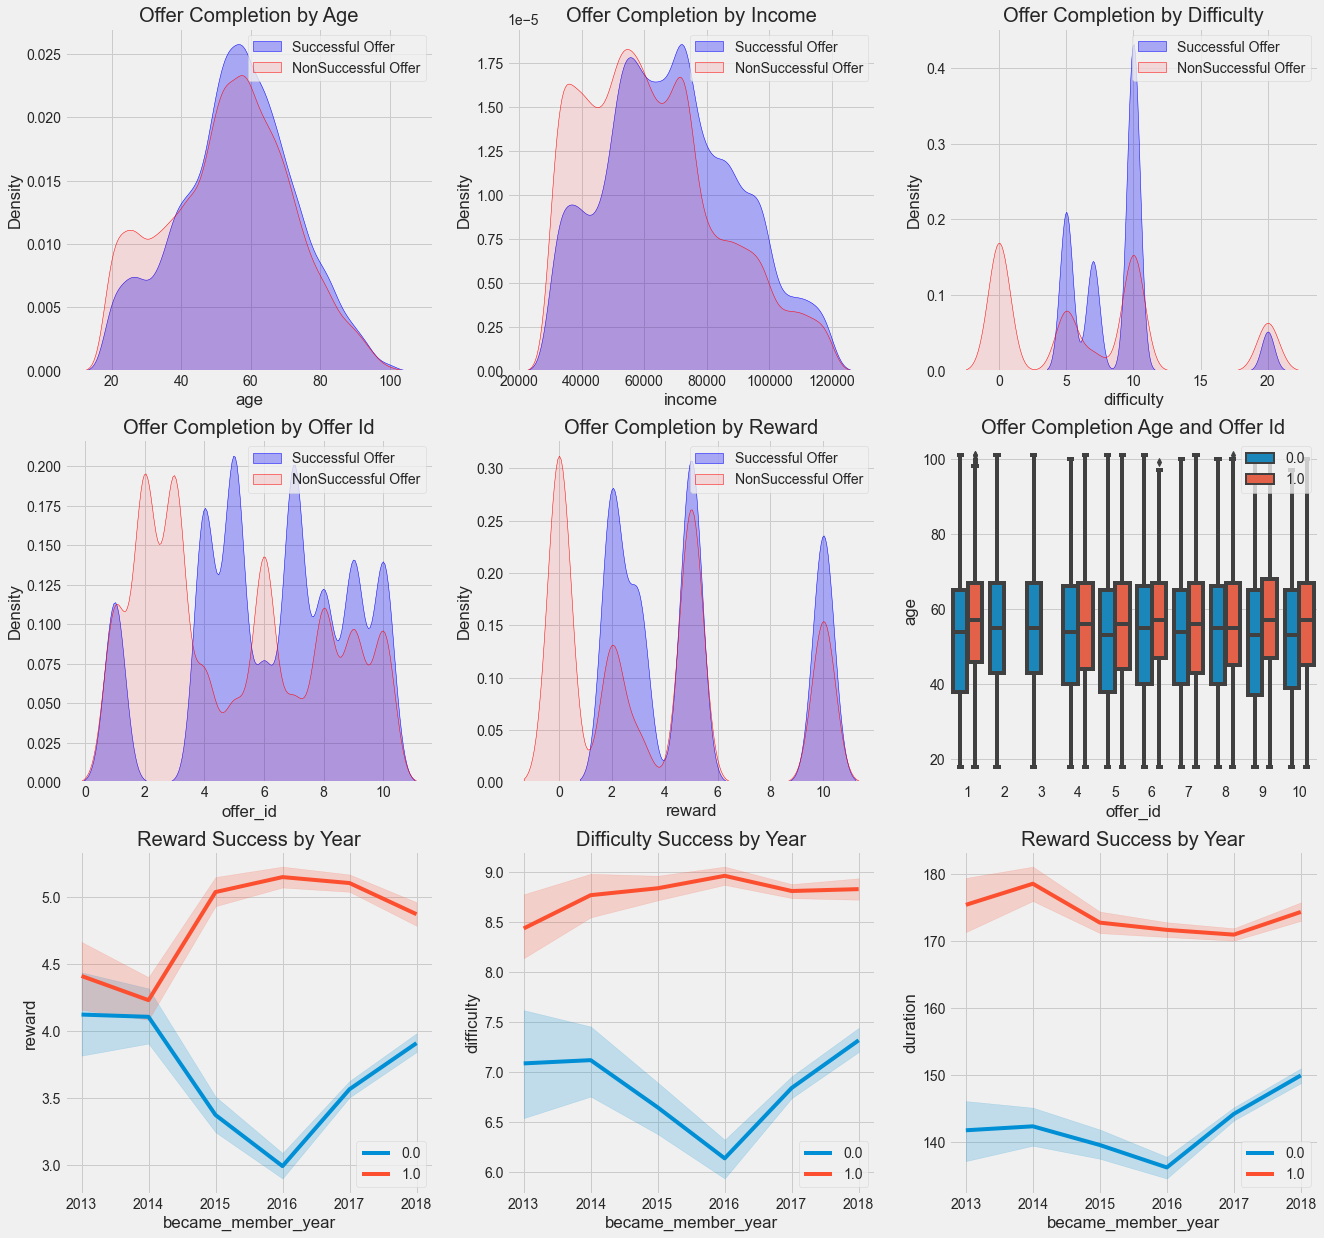

In [377]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20,20))

plt.style.use("fivethirtyeight")

sns.distplot(master_df[master_df['successful_offer']==1]['age'],color='blue',ax=axs[0,0], label='Successful Offer', kde_kws={'alpha': .3, 'shade':True}, hist=False);
sns.distplot(master_df[master_df['successful_offer']==0]['age'],color='red',ax=axs[0,0], label='NonSuccessful Offer', kde_kws={'alpha': .1, 'shade':True}, hist=False);
axs[0,0].set_title('Offer Completion by Age')
axs[0,0].legend()


sns.distplot(master_df[master_df['successful_offer']==1]['income'],color='blue',ax=axs[0,1], label='Successful Offer', kde_kws={'alpha': 0.3, 'shade':True}, hist=False);
sns.distplot(master_df[master_df['successful_offer']==0]['income'],color='red',ax=axs[0,1], label='NonSuccessful Offer', kde_kws={'alpha': 0.1, 'shade':True}, hist=False);
axs[0,1].set_title('Offer Completion by Income')
axs[0,1].legend()

sns.distplot(master_df[master_df['successful_offer']==1]['difficulty'],color='blue',ax=axs[0,2], label='Successful Offer', kde_kws={'alpha': 0.3, 'shade':True}, hist=False);
sns.distplot(master_df[master_df['successful_offer']==0]['difficulty'],color='red',ax=axs[0,2], label='NonSuccessful Offer', kde_kws={'alpha': 0.1, 'shade':True}, hist=False);
axs[0,2].set_title('Offer Completion by Difficulty')
axs[0,2].legend()

sns.distplot(master_df[master_df['successful_offer']==1]['offer_id'],color='blue',ax=axs[1,0], label='Successful Offer', kde_kws={'alpha': 0.3, 'shade':True}, hist=False);
sns.distplot(master_df[master_df['successful_offer']==0]['offer_id'],color='red', ax=axs[1,0], label='NonSuccessful Offer', kde_kws={'alpha': 0.1, 'shade':True}, hist=False);
axs[1,0].set_title('Offer Completion by Offer Id')
axs[1,0].legend()


sns.distplot(master_df[master_df['successful_offer']==1]['reward'],color='blue', label='Successful Offer', kde_kws={'alpha': .3, 'shade':True}, hist=False, ax=axs[1,1]);
sns.distplot(master_df[master_df['successful_offer']==0]['reward'],color='red', label='NonSuccessful Offer', kde_kws={'alpha': .1, 'shade':True}, hist=False, ax=axs[1,1]);
axs[1,1].set_title('Offer Completion by Reward')
axs[1,1].legend()

sns.boxplot(data=master_df, x="offer_id", y="age", hue='successful_offer', ax=axs[1,2])
axs[1,2].set_title('Offer Completion Age and Offer Id')
axs[1,2].legend(loc='upper right') # interestingly there are no successfull offers for offer#2&3


sns.lineplot(data=master_df, x='became_member_year', y='reward', markers=True,hue='successful_offer',ax=axs[2,0])
axs[2,0].set_title('Reward Success by Year')
axs[2,0].legend(loc='lower right')

sns.lineplot(data=master_df, x='became_member_year', y='difficulty', markers=True,hue='successful_offer',ax=axs[2,1])
axs[2,1].set_title('Difficulty Success by Year')
axs[2,1].legend(loc='lower right')

sns.lineplot(data=master_df, x='became_member_year', y='duration', markers=True,hue='successful_offer',ax=axs[2,2])
axs[2,2].set_title('Reward Success by Year')
axs[2,2].legend(loc='lower right')


plt.show()

In [365]:
# Now, I'd like to OHE the offer column:
# master_df.drop(columns=['age'], axis=1, inplace=True)
master_df = pd.get_dummies(master_df, columns = ['offer_id'])
master_df.head()

# Data Modeling👨‍💻🤖:
First, we must determine our predictor features (X) and target variable (y). Knwoing that ML algorithms only perform with numeric data, I will remove any string or time features:


In [117]:
master_df.dtypes

customer_id                         object
offer received                     float64
offer viewed                       float64
successful_offer                   float64
reward                               int64
difficulty                           int64
duration                             int64
email                                int64
mobile                               int64
social                               int64
web                                  int64
offer_type_bogo                      uint8
offer_type_discount                  uint8
offer_type_informational             uint8
became_member_on            datetime64[ns]
income                             float64
gender_F                             uint8
gender_M                             uint8
gender_O                             uint8
age_by_decade_10s                    uint8
age_by_decade_20s                    uint8
age_by_decade_30s                    uint8
age_by_decade_40s                    uint8
age_by_deca

In [366]:
master_df.drop(['customer_id','email','became_member_month','became_member_year','became_member_on'], axis=1, inplace=True)
# master_df = master_df[master_df.columns.drop(list(master_df.filter(regex='Test')))]

In [353]:
master_df

,offer received,offer viewed,successful_offer,reward,difficulty,duration,mobile,social,web,offer_type_bogo,...,offer_id_1,offer_id_10,offer_id_2,offer_id_3,offer_id_4,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9
0,1.0,0.0,0.0,2,10,168,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,1.0,1.0,0.0,0,0,96,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,1.0,1.0,0.0,0,0,72,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1.0,1.0,1.0,5,5,120,1,1,1,1,...,0,0,0,0,1,0,0,0,0,0
4,1.0,1.0,1.0,2,10,240,1,1,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55217,2.0,2.0,1.0,5,5,120,1,1,1,1,...,0,0,0,0,1,0,0,0,0,0
55218,1.0,1.0,1.0,5,20,240,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
55219,3.0,3.0,1.0,2,10,168,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
55220,1.0,1.0,1.0,5,5,168,1,0,1,1,...,0,0,0,0,0,0,0,0,1,0


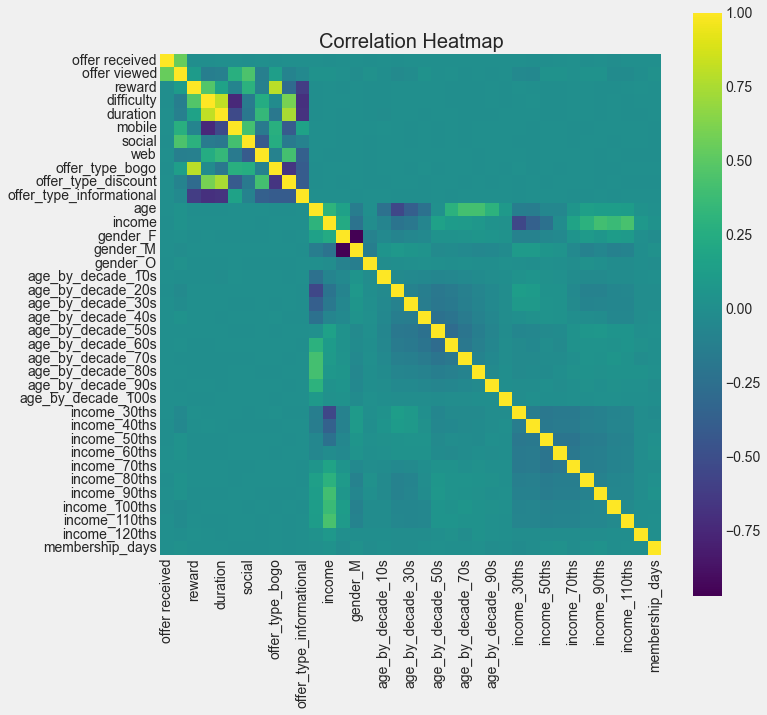

In [378]:
# Drop meaningless features
master_df.drop(['customer_id','email','became_member_month','became_member_year','became_member_on'], axis=1, inplace=True)

# predictive variables
X = master_df.drop(columns=['successful_offer'])
# target variable
y = master_df['successful_offer']

# Correlation
plt.figure(figsize=(10,10))
sns.heatmap(X.corr(),square=True, cmap='viridis');
plt.title('Correlation Heatmap', fontsize=20);

In [306]:
X

,offer received,offer viewed,transaction,reward,difficulty,duration,mobile,social,web,offer_type_bogo,...,offer_id_10,offer_id_11,offer_id_2,offer_id_3,offer_id_4,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9
0,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1.0,NaN,NaN,2.0,10.0,168.0,1.0,0.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0
2,1.0,1.0,NaN,0.0,0.0,96.0,1.0,0.0,1.0,0.0,...,0,0,0,1,0,0,0,0,0,0
3,1.0,1.0,NaN,0.0,0.0,72.0,1.0,1.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
4,1.0,1.0,NaN,5.0,5.0,120.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69709,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
69710,1.0,1.0,NaN,5.0,20.0,240.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
69711,3.0,3.0,NaN,2.0,10.0,168.0,1.0,0.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0
69712,1.0,1.0,NaN,5.0,5.0,168.0,1.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1


In [369]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

features_to_scale = ['membership_days', 'income', 'reward', 'difficulty', 'duration']

def scale_features(df, features_to_scale):
    '''
    Replace "unscaled" features in a df with scaled features
    
    INPUT:
    - df (dataframe): df containing features to scale
    - features_to_scale (list): list of features to scale
    
    OUTPUT:
    - df_scaled (dataframe): updated df containing scaled features (original "unscaled" features replaced)
    '''
    
    # df with features to scale
    df_features_scale = df[features_to_scale]
    
    # Initialize scaler and apply feature scaling to df
    scaler = MinMaxScaler()
    df_features_scale = pd.DataFrame(scaler.fit_transform(df_features_scale), columns=df_features_scale.columns, index=df_features_scale.index)
    
    # Drop orignal features from df and replace with scaled features 
    df = df.drop(columns=features_to_scale, axis=1)
    df_scaled = pd.concat([df, df_features_scale], axis=1)
    
    return df_scaled

# Applying the function to features:
X_train_scaled = scale_features(X_train, features_to_scale)

In [380]:
print(round(y_train.value_counts(normalize=True)*100,2))

1.0    53.36
0.0    46.64
Name: successful_offer, dtype: float64


- Target variable is distributed 53.36% and 46.64% for class 1 and 0, respectively. Therefore, our data is approximately balanced and we do not have to implement techniques to deal with unbalanced data (i.e. oversampling minority class, etc.)

- I will use the F1-Score to measure the competency of the model because the F1-Score metric is “the harmonic mean of the precision and recall metrics” 


In [372]:
#### Train classifiers and determine the best estimator using GridSearchCV

from datetime import datetime as dt

def fit_classifier(clf, param_grid, X=X_train_scaled.values, y=y_train.values):
    '''
    1) Fit a classifier on training data using GridSearchCV and provide F1-Score
    2) Collect timed results for each classifier
    
    INPUT:
    - clf               : classifier to fit
    - param_grid (dict) : parameters to use with GridSearchCV
    - X                 : X train values
    - y                 : y train target values
    
    OUTPUT:
    - classifier results
    '''
    
    start_time = dt.now()
    
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='f1', cv=5, verbose=0)
    print("Fitting {} :".format(clf.__class__.__name__))
    grid.fit(X, y)
    total_time = (dt.now()-start_time).seconds
    
    print(clf.__class__.__name__)
    print('Duration (seconds): {}'.format(total_time))
    print('Best F1_Score: {}'.format(round(grid.best_score_, 3)))
    print("-"*50)
    
    return total_time, grid.best_score_, grid.best_estimator_


In [381]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

# initialize classification models:
rfc = RandomForestClassifier(random_state=123) # RandomForestClassifier
gbc = GradientBoostingClassifier(random_state=123) # GradientBoostingClassifier
ada = AdaBoostClassifier(random_state=123) # AdaBoostClassifier

cl_names = []
cl_scores = []
cl_best_ests = []
cl_time_taken = []
cl_dict = {}

for classifier in [rfc, ada, gbc]:
    total_time, best_score, best_est = fit_classifier(classifier, {})
    cl_names.append(classifier.__class__.__name__)
    cl_scores.append(best_score)
    cl_best_ests.append(best_est)
    cl_time_taken.append(total_time)

Fitting RandomForestClassifier :
RandomForestClassifier
Duration (seconds): 19
Best F1_Score: 0.804
--------------------------------------------------
Fitting AdaBoostClassifier :
AdaBoostClassifier
Duration (seconds): 9
Best F1_Score: 0.822
--------------------------------------------------
Fitting GradientBoostingClassifier :
GradientBoostingClassifier
Duration (seconds): 33
Best F1_Score: 0.829
--------------------------------------------------


In [ ]:
# This was going on for 3+ hours so I decided to stop the kernel because of time constraints

# len(X_train_scaled)*0.01*2
# param_grid = {
#     "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
#     'min_samples_split': [128, 257, 515], # This should be ~0.5-1% of total values. Since this is imbalanced class problem, we’ll take a small value from the range.
#     "min_samples_leaf": range(30, 81, 10),  # Can be selected based on intuition. This is just used for preventing overfitting and again a small value because of imbalanced classes.
#     'max_depth': [6,8], # Should be chosen (5-8) based on the number of observations and predictors.
#     "max_features":range(7,20,2), # Its a general thumb-rule to start with square root. ['sqrt']
#     # For subsample:
#     # - The fraction of observations to be selected for each tree. Selection is done by random sampling.
#     # - Values slightly less than 1 make the model robust by reducing the variance.
#     # - Typical values ~0.8 generally work fine but can be fine-tuned further.
#     "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],    
#     "n_estimators":range(10,81,10) # The number of sequential trees to be modeled
#     }

# gbc = GradientBoostingClassifier(random_state=123)
# gbc_best_score, gbc_best_est, _ = fit_classifier(gbc, param_grid)
# gbc_best_est

In [345]:
gbc.fit(X_train_scaled, y_train)

# Let's not forget to scale the X_test since we trained the model on X_train_scaled. Else the prediction will be much worse.
X_test_scaled = scale_features(X_test, features_to_scale)
gbc_y_pred = gbc.predict(X_test_scaled)
print('F1 Score: {}'.format(round(f1_score(gbc_y_pred, y_test),3)))

F1 Score: 0.826


Text(0.5, 1.0, 'Classification Report')

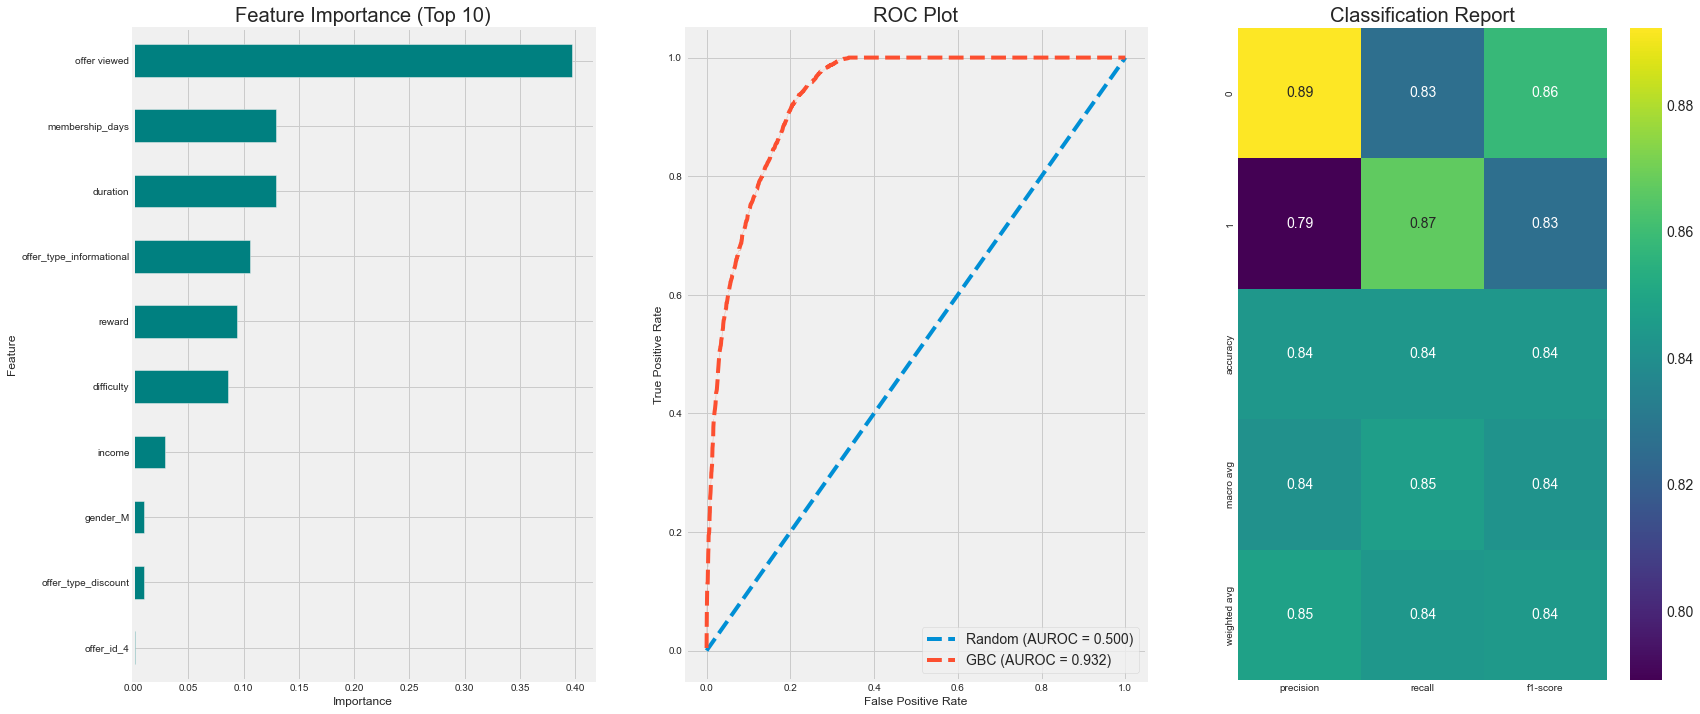

In [346]:
fig, axs = plt.subplots(ncols=3, figsize=(25,12))

plt.style.use("fivethirtyeight")

feature_importance = gbc.feature_importances_
columns = X_train_scaled.columns
gbc_coeff = pd.Series(feature_importance, columns).sort_values(ascending=False)[:10]
gbc_coeff.sort_values().plot.barh(color='teal',ax=axs[0])
axs[0].set_title('Feature Importance (Top 10)')
axs[0].set_xlabel('Importance')
axs[0].set_ylabel('Feature')


r_probs = [0 for _ in range(len(y_test))]
gbc_probs = gbc.predict_proba(X_test_scaled)
gbc_probs = gbc_probs[:,1]
from sklearn.metrics import roc_curve, roc_auc_score
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
gbc_fpr, gbc_tpr, _ = roc_curve(y_test, gbc_probs)
# ROC is the receiver operating characteristics AUROC is the area under the ROC curve
r_auc = roc_auc_score(y_test, r_probs)
gbc_auc = roc_auc_score(y_test, gbc_probs)
sns.lineplot(x=r_fpr, y=r_tpr,linestyle='--',label='Random (AUROC = %0.3f)' % r_auc, ax=axs[1])
sns.lineplot(x=gbc_fpr, y=gbc_tpr,linestyle='--',label='GBC (AUROC = %0.3f)' % gbc_auc, ax=axs[1])
axs[1].set_title('ROC Plot')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')


from sklearn.metrics import classification_report
true = y_test
pred = gbc_y_pred
target_names = [0,1]
clf_report = classification_report(true,
                                   pred,
                                   target_names=target_names,
                                   output_dict=True)

sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,cmap='viridis',ax=axs[2])
axs[2].set_title('Classification Report')

# confusion = confusion_matrix(y_test,gbc_y_pred)
# sns.heatmap(confusion/np.sum(confusion),annot=True,fmt='.2%', cmap='Blues',ax=axs[2])
# axs[2].set_title('Confusion Matrix (%)')
# axs[2].set_xlabel('Predicted')
# axs[2].set_ylabel('True')

In [ ]:



est = sm.OLS(y, X2)
est2 = gbc.fit(X_train_scaled, y_train)
print(est2.summary())